In [1]:
import os

import numpy as np
import rasterio as rio

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.exposure import equalize_adapthist

import matplotlib.pyplot as plt

In [2]:
path = 'UPDATE_unsupervised/clipped/'
complete_dataset = os.listdir(path)
complete_dataset = [path + x for x in complete_dataset]
print(complete_dataset)

['UPDATE_unsupervised/clipped/clip_B7.tif', 'UPDATE_unsupervised/clipped/clip_B6.tif', 'UPDATE_unsupervised/clipped/clip_B4.tif', 'UPDATE_unsupervised/clipped/clip_B5.tif', 'UPDATE_unsupervised/clipped/clip_B1.TIF', 'UPDATE_unsupervised/clipped/clip_B2.tif', 'UPDATE_unsupervised/clipped/clip_B3.tif']


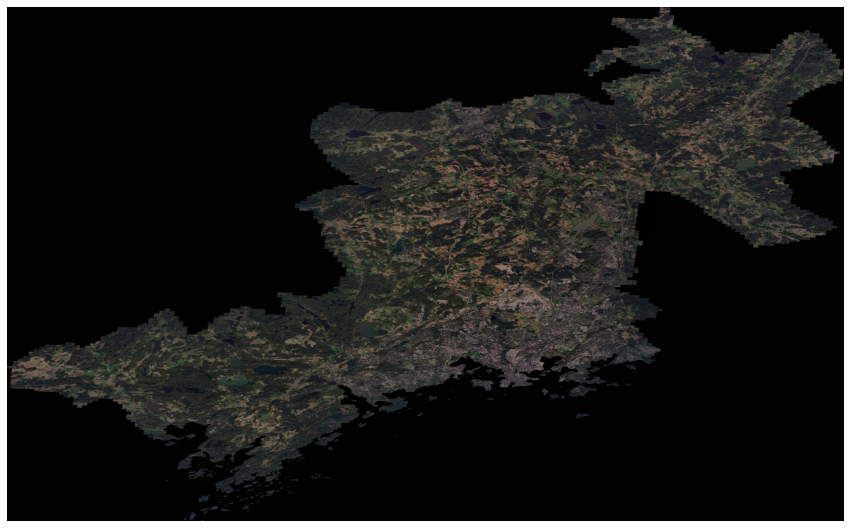

In [9]:
def show_rgb(bands_list, red=4, green=3, blue=2):
    stack = []
    
    colors = [red, green, blue]
    colors = ['B' + str(x) for x in colors]
    
    for color in colors:
        for band in bands_list:
            if color in band:
                with rio.open(band) as src:
                    array = src.read(1) / 55000
                    stack.append(array)
                break
                
    stack = np.dstack(stack)
    for i in range(0, 3):
        stack[:, :, i] = equalize_adapthist(stack[:, :, i], clip_limit=0.025)
        
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(stack)
    plt.show()

show_rgb(complete_dataset)

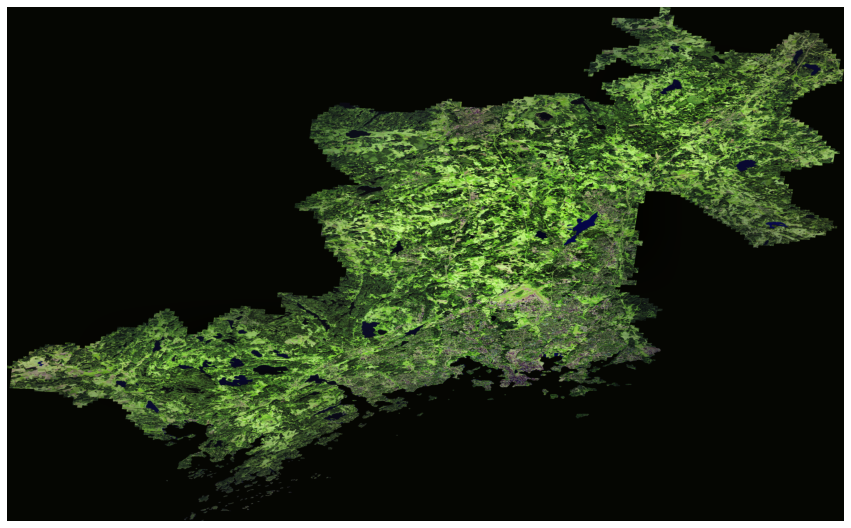

In [10]:
show_rgb(complete_dataset, red=7, green=6, blue=4)

In [42]:
class ClusteredBands:
    
    def __init__(self, rasters_list):
        self.rasters = rasters_list
        self.model_input = None
        self.width = 0
        self.height = 0
        self.depth = 0
        self.no_of_ranges = None
        self.models = None
        self.predicted_rasters = None
        self.s_scores = []
        self.inertia_scores = []
        
    def set_raster_stack(self):
        band_list = []
        for image in self.rasters:
            with rio.open(image, 'r') as src:
                band = src.read(1)
                band = np.nan_to_num(band)
                band_list.append(band)
        bands_stack = np.dstack(band_list)
        
        # Prepare model input from bands stack
        self.width, self.height, self.depth = bands_stack.shape
        self.model_input = bands_stack.reshape(self.width * self.height, self.depth)
        
    def build_models(self, no_of_clusters_range):
        self.no_of_ranges = no_of_clusters_range
        models = []
        predicted = []
        inertia_vals = []
        s_scores = []
        for n_clust in no_of_clusters_range:
            kmeans = KMeans(n_clusters=n_clust)
            y_pred = kmeans.fit_predict(self.model_input)
            
            # Append model
            models.append(kmeans)
            
            # Calculate metrics
            s_scores.append(self._calc_s_score(y_pred))
            inertia_vals.append(kmeans.inertia_)
            
            # Append output image (classified)
            quantized_raster = np.reshape(y_pred, (self.width, self.height))
            predicted.append(quantized_raster)
            
        # Update class parameters
        self.models = models
        self.predicted_rasters = predicted
        self.s_scores = s_scores
        self.inertia_scores = inertia_vals
        
    def _calc_s_score(self, labels):
        s_score = silhouette_score(self.model_input, labels, sample_size=1000)
        return s_score
        
    def show_clustered(self):
        for idx, no_of_clust in enumerate(self.no_of_ranges):
            title = 'Number of clusters: ' + str(no_of_clust)
            image = self.predicted_rasters[idx]
            plt.figure(figsize = (15,15))
            plt.axis('off')
            plt.title(title)
            plt.imshow(image, cmap=plt.cm.get_cmap('Pastel1'))
            plt.colorbar()
            plt.show()
            
    def show_inertia(self):
        plt.figure(figsize = (10,10))
        plt.title('Inertia of the models')
        plt.plot(self.no_of_ranges, self.inertia_scores)
        plt.show()
        
    def show_silhouette_scores(self):
        plt.figure(figsize = (10,10))
        plt.title('Silhouette scores')
        plt.plot(self.no_of_ranges, self.s_scores)
        plt.show()

In [43]:
clustered_models = ClusteredBands(complete_dataset)
clustered_models.set_raster_stack()

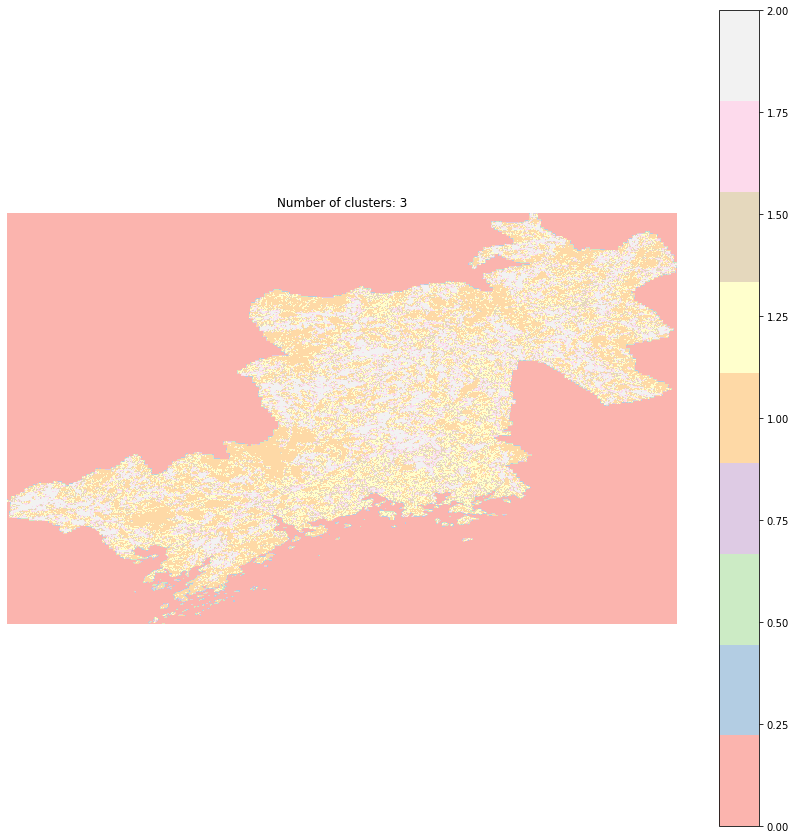

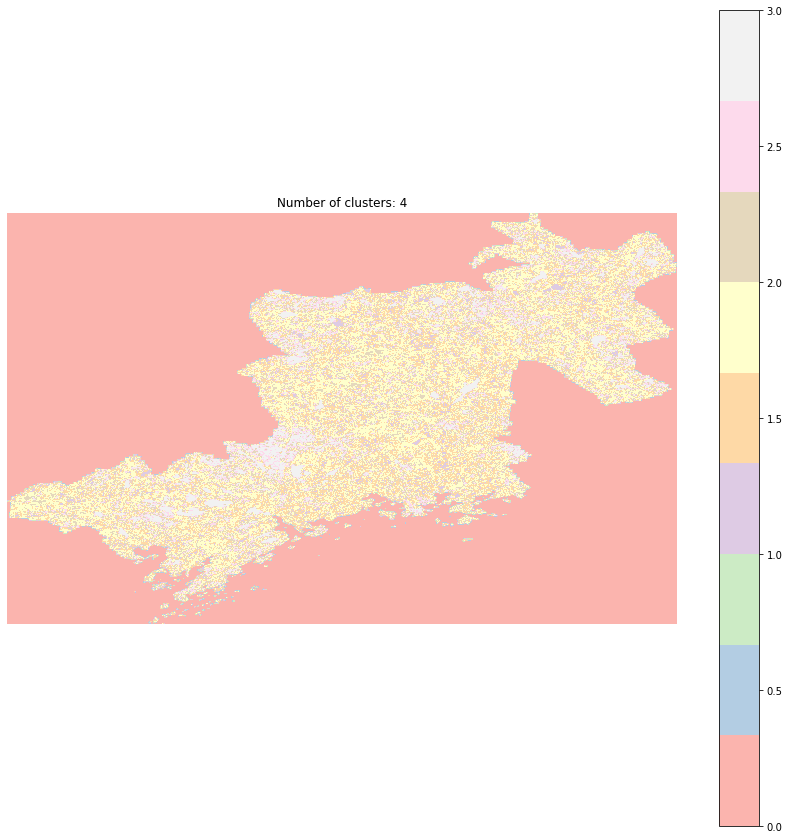

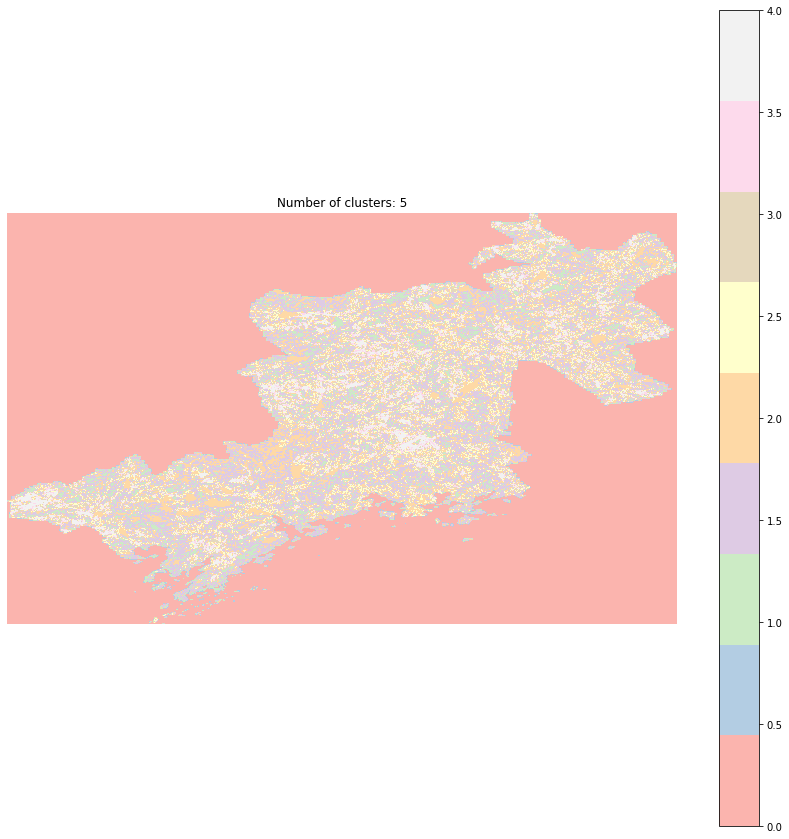

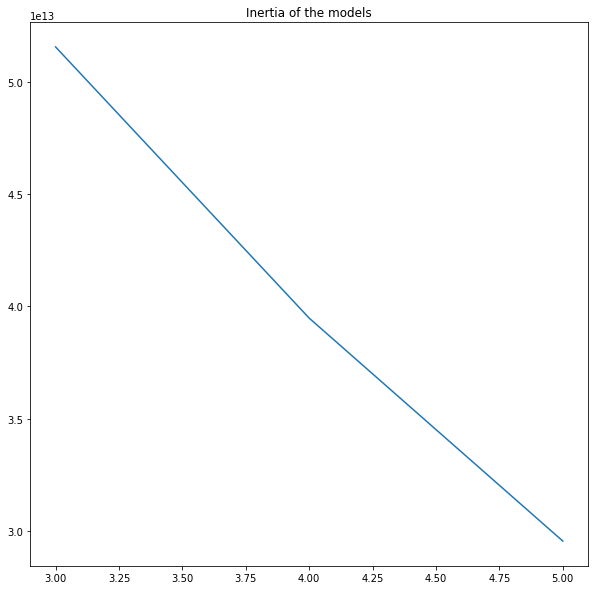

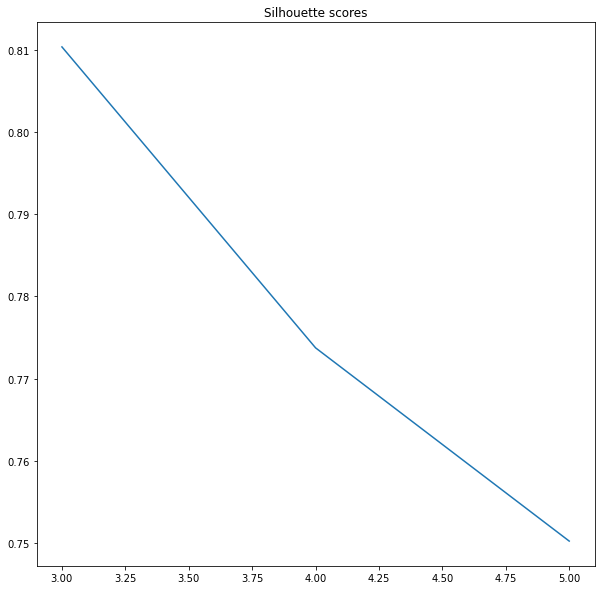

In [44]:
ranges = np.arange(3, 6, 1)
clustered_models.build_models(ranges)
clustered_models.show_clustered()
clustered_models.show_inertia()
clustered_models.show_silhouette_scores()

In [36]:
def get_spectral_indices(labeled_image: np.array, rasters: list) -> dict:
    """
    Function creates list of the unique spectral indices for each label from unsupervised classified image.
    
    :param labeled_image: (numpy array) classification output,
    :param rasters: (list) list of files with Landsat 8 bands.
    
    :returns: (dict) {raster: {label: [indices]}}
    """
    spectral_indices = {}
    
    for image in rasters:
        with rio.open(image, 'r') as src:
            
            band = src.read(1)
            band = np.nan_to_num(band)
            spectral_indices[image] = {}
            
            for lbl in np.unique(labeled_image):
                indices = band[labeled_image == lbl]
                unique_indices = np.unique(indices)
                spectral_indices[image][lbl] = unique_indices
    return spectral_indices

In [37]:
four_class_spectral_indices = get_spectral_indices(clustered_models.predicted_rasters[1], complete_dataset)

In [38]:
four_class_spectral_indices

{'UPDATE_unsupervised/clipped/clip_B7.tif': {0: array([0], dtype=uint16),
  1: array([  888,  1011,  1018, ..., 10452, 10756, 12777], dtype=uint16),
  2: array([   0,   29,  153, ..., 8077, 8124, 9119], dtype=uint16),
  3: array([ 1877,  1916,  1968, ..., 48998, 52272, 55000], dtype=uint16)},
 'UPDATE_unsupervised/clipped/clip_B6.tif': {0: array([0], dtype=uint16),
  1: array([ 2728,  2745,  2834, ..., 11636, 11789, 11890], dtype=uint16),
  2: array([ 193,  205,  274, ..., 9779, 9838, 9864], dtype=uint16),
  3: array([ 4827,  4844,  4912, ..., 44226, 45327, 55000], dtype=uint16)},
 'UPDATE_unsupervised/clipped/clip_B4.tif': {0: array([0], dtype=uint16),
  1: array([ 1673,  2158,  2842, ..., 11228, 11270, 11911], dtype=uint16),
  2: array([ 1800,  2410,  2422, ...,  9156,  9223, 12038], dtype=uint16),
  3: array([ 3094,  3141,  3147, ..., 46576, 51545, 55000], dtype=uint16)},
 'UPDATE_unsupervised/clipped/clip_B5.tif': {0: array([0], dtype=uint16),
  1: array([ 4498,  5648,  5858, ..., 